# Tutorial 2: Performing CAPs Analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/donishadsmith/neurocaps/blob/stable/docs/tutorials/tutorial-2.ipynb) [![Github](https://img.shields.io/badge/Go_to_Source-black.svg?logo=github)](https://github.com/donishadsmith/neurocaps/blob/stable/docs/tutorials/tutorial-2.ipynb)

The ``CAP`` class is designed to perform CAPs analyses (on all subjects or group of subjects). It offers the flexibility
to analyze data from all subjects or focus on specific groups, compute CAP-specific metrics, and generate visualizations
to aid in the interpretation of results.


In [14]:
# Allow plotly to render correctly on static websites
import plotly.io as pio

pio.renderers.default = "svg"

# Download packages
try:
    import neurocaps
except:
    !pip install neurocaps[windows,demo]

# Set headless display for google colab
import os, sys

if "google.colab" in sys.modules:
    os.environ["DISPLAY"] = ":0.0"
    !apt-get install -y xvfb
    !Xvfb :0 -screen 0 1024x768x24 &> /dev/null &
    !Xvfb :0 -screen 0 1024x768x24 &> /dev/null &

# Performing CAPs on All Subjects
All information pertaining to CAPs (k-means models, activation vectors/cluster centroids, etc) are stored as attributes
in the ``CAP`` class and this information is used by all methods in the class. These attributes are accessible via
[properties](https://neurocaps.readthedocs.io/en/stable/generated/neurocaps.analysis.CAP.html#properties).
**Some properties can also be used as setters.**

In [15]:
# Extract Timeseries Data
import numpy as np

from neurocaps.extraction import TimeseriesExtractor
from neurocaps.utils import simulate_bids_dataset

np.random.seed(0)

bids_root = simulate_bids_dataset(output_dir="neurocaps_demo")

extractor = TimeseriesExtractor()
extractor.get_bold(bids_dir=bids_root, task="rest", verbose=False)

2026-01-27 14:01:03,521 neurocaps.utils.samples_generators [WARNING] `output_dir` already exists. Returning the `output_dir` string.
2026-01-27 14:01:03,522 neurocaps.utils._parcellation_validation [WARNING] `parcel_approach` is None, defaulting to 'Schaefer'.
2026-01-27 14:01:03,823 neurocaps.extraction._internals.confounds [INFO] Confound regressors to be used if available: cosine*, trans_x, trans_x_derivative1, trans_y, trans_y_derivative1, trans_z, trans_z_derivative1, rot_x, rot_x_derivative1, rot_y, rot_y_derivative1, rot_z, rot_z_derivative1, a_comp_cor_00, a_comp_cor_01, a_comp_cor_02, a_comp_cor_03, a_comp_cor_04, a_comp_cor_05.


2026-01-27 14:01:12,669 neurocaps.analysis.cap._internals.cluster [INFO] No groups specified. Using default group 'All Subjects' containing all subject IDs from `subject_timeseries`. The `groups` dictionary will remain fixed unless the `CAP` class is re-initialized or `clear_groups()` is used.
2026-01-27 14:01:12,780 neurocaps.analysis.cap._internals.cluster [INFO] [GROUP: All Subjects | METHOD: elbow] Optimal cluster size is 4.


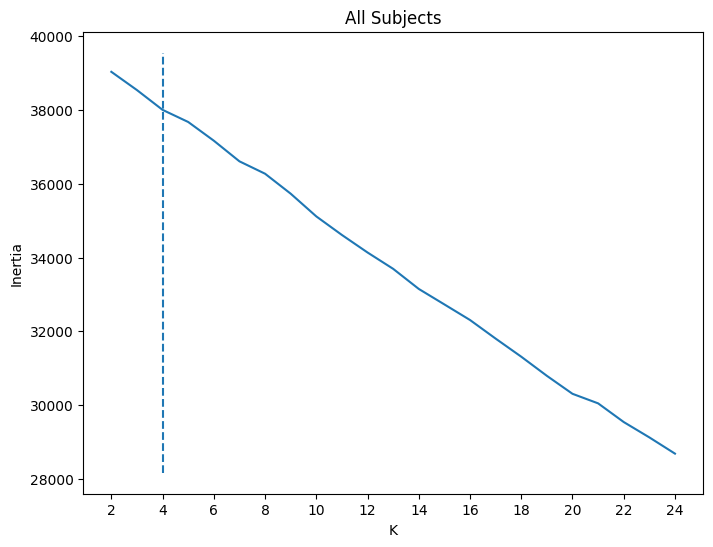

In [16]:
from neurocaps.analysis import CAP
from neurocaps.utils import PlotDefaults

# Extracting timseries
parcel_approach = {"Schaefer": {"n_rois": 100, "yeo_networks": 7, "resolution_mm": 2}}

# Initialize CAP class
cap_analysis = CAP(parcel_approach=parcel_approach)

# Get CAPs
plot_kwargs = {**PlotDefaults.get_caps(), "step": 2}

cap_analysis.get_caps(
    subject_timeseries=extractor.subject_timeseries,
    n_clusters=range(2, 25),
    random_state=0,
    cluster_selection_method="elbow",
    show_figs=True,
    progress_bar=False,
    **plot_kwargs,
)

``print`` can be used to return a string representation of the ``CAP`` class.

In [17]:
print(cap_analysis)

Current Object State:
Parcellation Approach                                       : Schaefer
Groups                                                      : All Subjects
Number of Clusters                                          : [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
Cluster Selection Method                                    : elbow
Optimal Number of Clusters (if Range of Clusters Provided)  : {'All Subjects': np.int64(4)}
CPU Cores Used for Clustering (Multiprocessing)             : None
User-Specified Runs IDs Used for Clustering                 : None
Concatenated Timeseries Bytes                               : 320184 bytes
Standardized Concatenated Timeseries                        : True
Co-Activation Patterns (CAPs)                               : {'All Subjects': 4}
Variance Explained by Clustering                            : {'All Subjects': np.float64(0.040390347159273476)}


## Calculate Metrics

Note that if ``standardize`` was set to True in ``CAP.get_caps()``, then the column (ROI) means and standard deviations
computed from the concatenated data used to obtain the CAPs are also used to standardize each subject in the timeseries
data inputted into ``CAP.calculate_metrics()``. This ensures proper CAP assignments for each subjects frames.


In [18]:
df_dict = cap_analysis.calculate_metrics(
    subject_timeseries=extractor.subject_timeseries,
    return_df=True,
    metrics=["temporal_fraction", "counts", "transition_probability"],
    continuous_runs=True,
    progress_bar=False,
)

df_dict["temporal_fraction"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3,CAP-4
0,0,All Subjects,run-0,0.12,0.47,0.12,0.29


## Plotting CAPs

2026-01-27 14:01:13,093 neurocaps.analysis.cap._internals.cluster [INFO] No groups specified. Using default group 'All Subjects' containing all subject IDs from `subject_timeseries`. The `groups` dictionary will remain fixed unless the `CAP` class is re-initialized or `clear_groups()` is used.


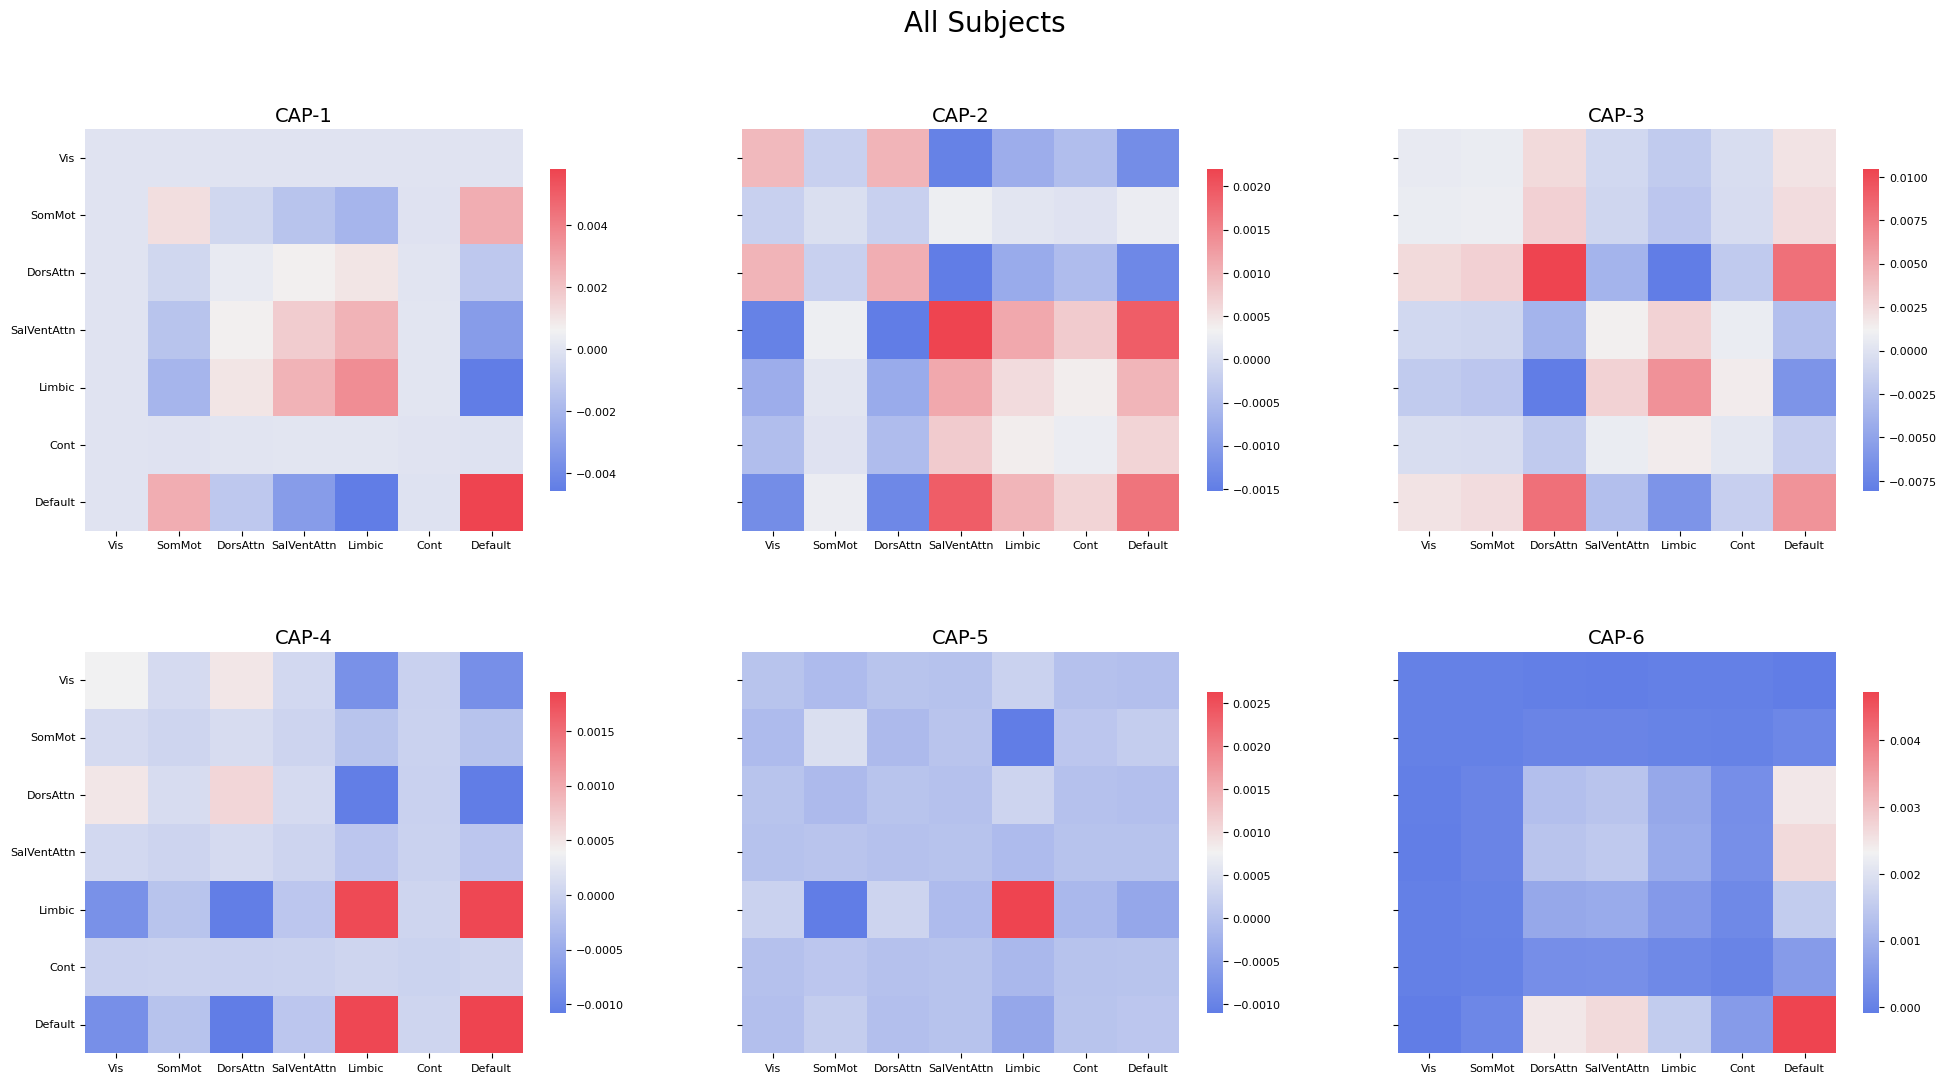

In [19]:
import seaborn as sns

cap_analysis = CAP(
    parcel_approach={"Schaefer": {"n_rois": 400, "yeo_networks": 7, "resolution_mm": 1}}
)

cap_analysis.get_caps(subject_timeseries=extractor.subject_timeseries, n_clusters=6)

sns.diverging_palette(145, 300, s=60, as_cmap=True)

palette = sns.diverging_palette(260, 10, s=80, l=55, n=256, as_cmap=True)

plot_kwargs = PlotDefaults.caps2plot()
plot_kwargs.update(
    {
        "subplots": True,
        "fontsize": 14,
        "ncol": 3,
        "sharey": True,
        "tight_layout": False,
        "xlabel_rotation": 0,
        "hspace": 0.3,
        "cmap": palette,
    }
)

cap_analysis.caps2plot(
    visual_scope="regions", plot_options="outer_product", show_figs=True, **plot_kwargs
)

**Note**: Outer product plots represent interactions, such that values indicate magnitude, positive values suggest that both networks either activate or deactivate together, and negative values suggest that one network activates while another deactivates.

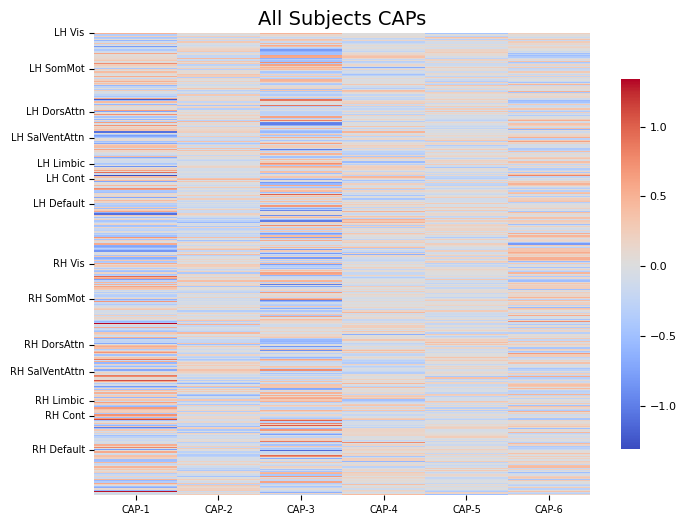

In [20]:
plot_kwargs = PlotDefaults.caps2plot()
plot_kwargs.update(dict(xticklabels_size=7, yticklabels_size=7))

cap_analysis.caps2plot(visual_scope="nodes", plot_options="heatmap", show_figs=True, **plot_kwargs)

## Generate Correlation Matrix

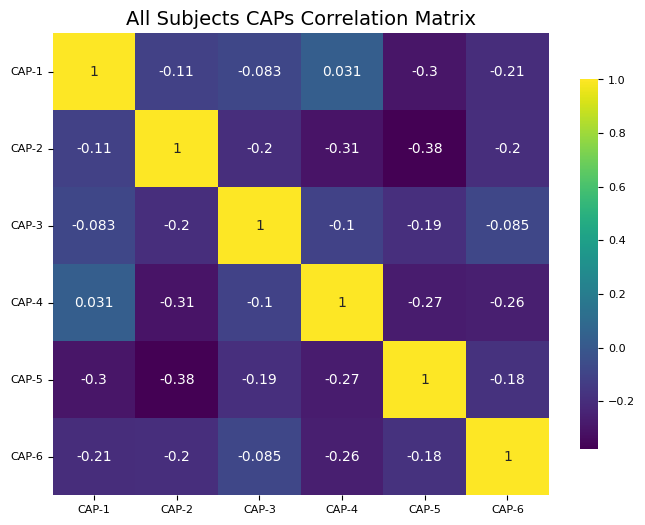

In [21]:
plot_kwargs = PlotDefaults.caps2corr()
plot_kwargs.update(dict(annot=True, cmap="viridis"))

cap_analysis.caps2corr(method="pearson", show_figs=True, **plot_kwargs)

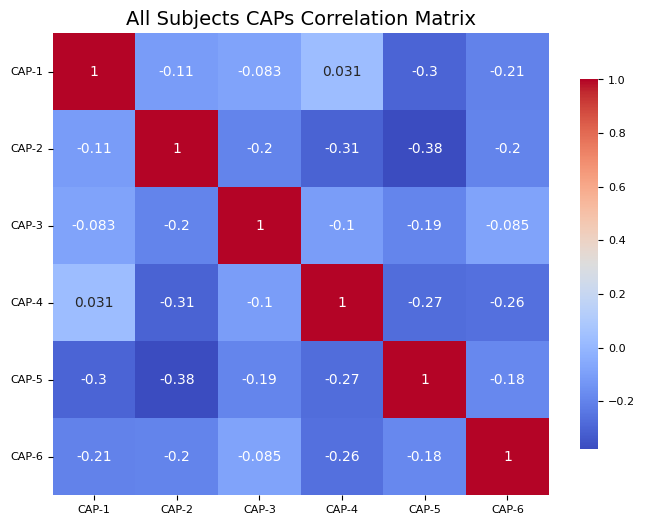

In [22]:
corr_dict = cap_analysis.caps2corr(method="pearson", return_df=True)

In [23]:
corr_dict["All Subjects"]

,CAP-1,CAP-2,CAP-3,CAP-4,CAP-5,CAP-6
CAP-1,1 (0)***,-0.11 (0.029)*,-0.083 (0.099),0.031 (0.54),-0.3 (1.1e-09)***,-0.21 (3.5e-05)***
CAP-2,-0.11 (0.029)*,1 (0)***,-0.2 (6e-05)***,-0.31 (3.7e-10)***,-0.38 (4.9e-15)***,-0.2 (6.9e-05)***
CAP-3,-0.083 (0.099),-0.2 (6e-05)***,1 (0)***,-0.1 (0.037)*,-0.19 (0.0001)***,-0.085 (0.09)
CAP-4,0.031 (0.54),-0.31 (3.7e-10)***,-0.1 (0.037)*,1 (0)***,-0.27 (2.9e-08)***,-0.26 (1.1e-07)***
CAP-5,-0.3 (1.1e-09)***,-0.38 (4.9e-15)***,-0.19 (0.0001)***,-0.27 (2.9e-08)***,1 (0)***,-0.18 (0.00024)***
CAP-6,-0.21 (3.5e-05)***,-0.2 (6.9e-05)***,-0.085 (0.09),-0.26 (1.1e-07)***,-0.18 (0.00024)***,1 (0)***


## Creating Surface Plots

**Note:** If the ``color_range`` kwarg is not used, each CAP will be scaled to its own maximum and minimum value. For directly comparable, zero-centered images, it is recommended to set a symmetric ``color_range`` based on the largest absolute value across all CAPs (e.g., if the largest absolute value is 0.96, use ``color_range=(-1.31, 1.31)``).

2026-01-27 14:01:16,922 neurocaps.analysis.cap._internals.surface [WARNING] TypeError raised by neuromaps due to changes in pathlib.py in Python 3.12 Converting NIfTI image into a temporary nii.gz file (which will be automatically deleted afterwards) [TEMP FILE: C:\Users\donis\AppData\Local\Temp\tmpf0uzx1do.nii.gz]


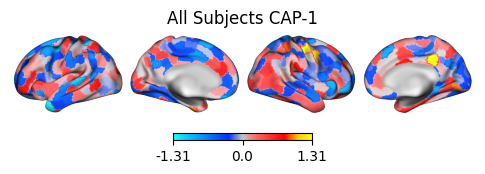

2026-01-27 14:01:19,922 neurocaps.analysis.cap._internals.surface [WARNING] TypeError raised by neuromaps due to changes in pathlib.py in Python 3.12 Converting NIfTI image into a temporary nii.gz file (which will be automatically deleted afterwards) [TEMP FILE: C:\Users\donis\AppData\Local\Temp\tmp1upol5nx.nii.gz]


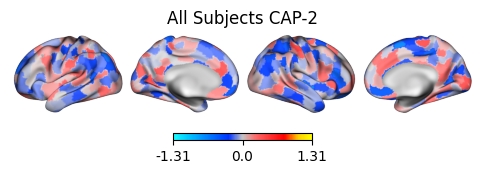

2026-01-27 14:01:22,975 neurocaps.analysis.cap._internals.surface [WARNING] TypeError raised by neuromaps due to changes in pathlib.py in Python 3.12 Converting NIfTI image into a temporary nii.gz file (which will be automatically deleted afterwards) [TEMP FILE: C:\Users\donis\AppData\Local\Temp\tmplgigw7vt.nii.gz]


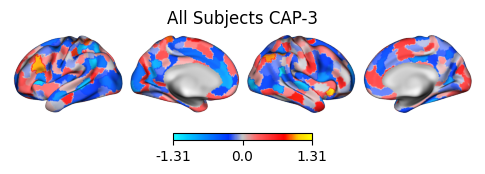

2026-01-27 14:01:26,118 neurocaps.analysis.cap._internals.surface [WARNING] TypeError raised by neuromaps due to changes in pathlib.py in Python 3.12 Converting NIfTI image into a temporary nii.gz file (which will be automatically deleted afterwards) [TEMP FILE: C:\Users\donis\AppData\Local\Temp\tmp6ende8_h.nii.gz]


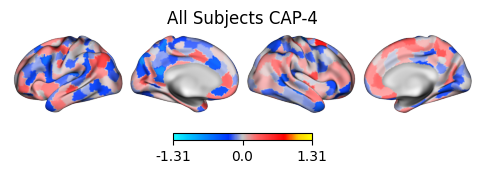

2026-01-27 14:01:29,147 neurocaps.analysis.cap._internals.surface [WARNING] TypeError raised by neuromaps due to changes in pathlib.py in Python 3.12 Converting NIfTI image into a temporary nii.gz file (which will be automatically deleted afterwards) [TEMP FILE: C:\Users\donis\AppData\Local\Temp\tmpssaw87bb.nii.gz]


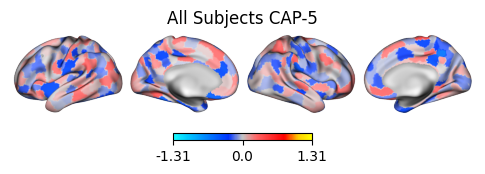

2026-01-27 14:01:32,151 neurocaps.analysis.cap._internals.surface [WARNING] TypeError raised by neuromaps due to changes in pathlib.py in Python 3.12 Converting NIfTI image into a temporary nii.gz file (which will be automatically deleted afterwards) [TEMP FILE: C:\Users\donis\AppData\Local\Temp\tmpbz_o9dal.nii.gz]


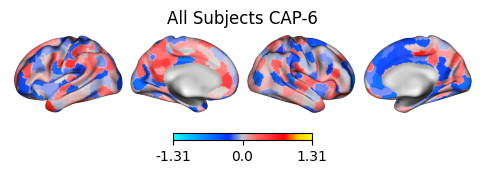

In [24]:
from matplotlib.colors import LinearSegmentedColormap

# Create the colormap
colors = [
    "#1bfffe",
    "#00ccff",
    "#0099ff",
    "#0066ff",
    "#0033ff",
    "#c4c4c4",
    "#ff6666",
    "#ff3333",
    "#FF0000",
    "#ffcc00",
    "#FFFF00",
]

custom_cmap = LinearSegmentedColormap.from_list("custom_cold_hot", colors, N=256)

plot_kwargs = PlotDefaults.caps2surf()
plot_kwargs.update(dict(cmap=custom_cmap, size=(500, 100), layout="row", color_range=(-1.31, 1.31)))

# Apply custom cmap to surface plots
cap_analysis.caps2surf(progress_bar=False, **plot_kwargs)

## Getting Network Alignment (Cosine Similarity)

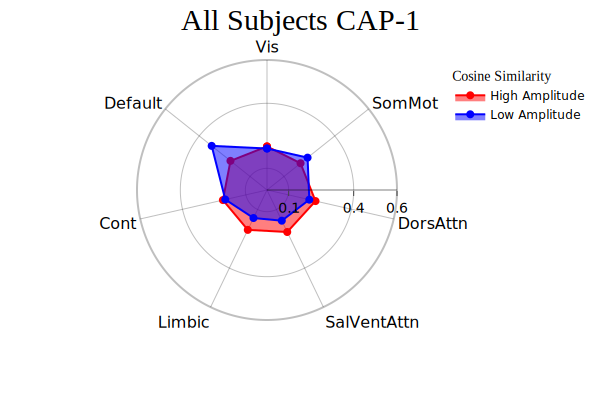

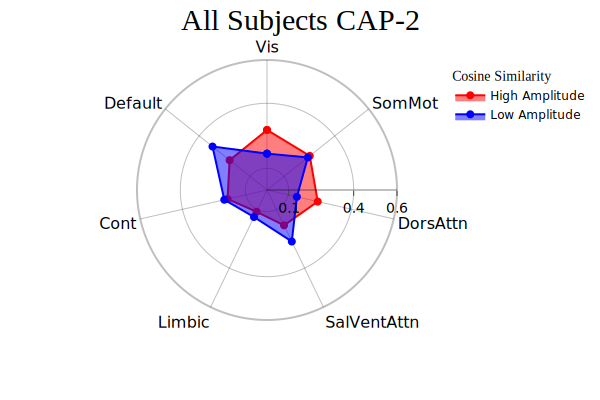

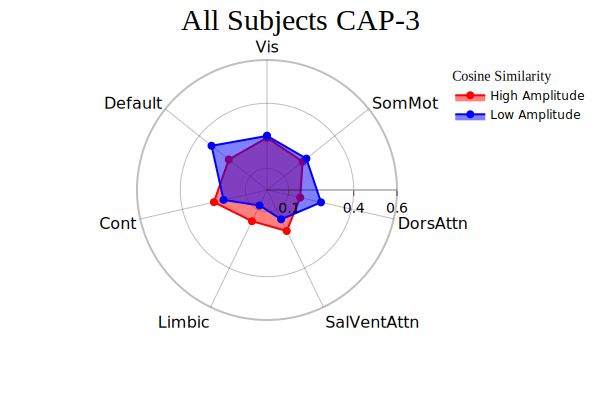

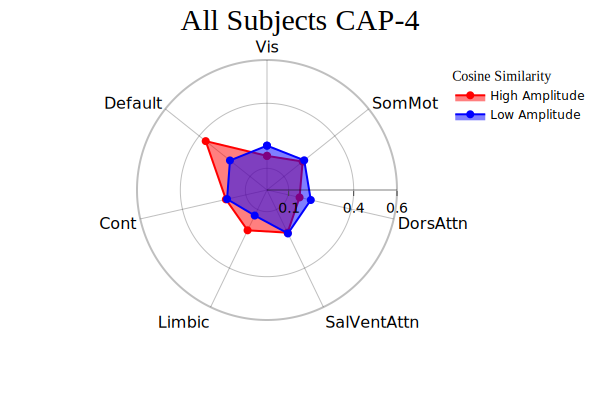

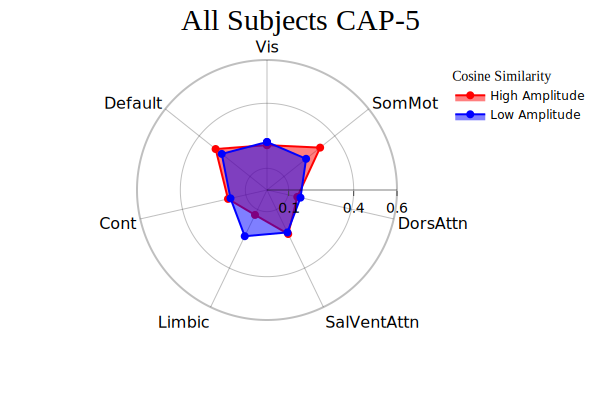

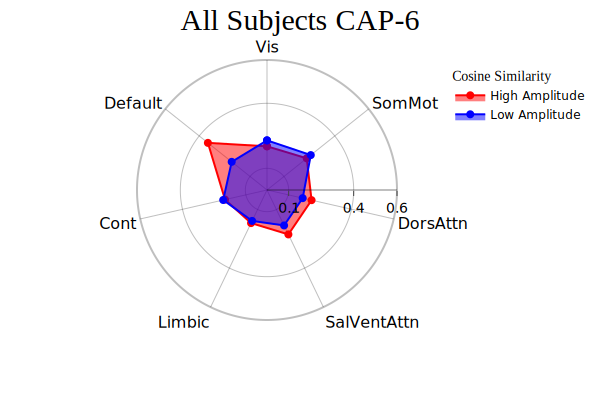

In [25]:
radialaxis = {
    "showline": True,
    "linewidth": 2,
    "linecolor": "rgba(0, 0, 0, 0.25)",
    "gridcolor": "rgba(0, 0, 0, 0.25)",
    "ticks": "outside",
    "tickfont": {"size": 14, "color": "black"},
    "range": [0, 0.6],
    "tickvals": [0.1, "", "", 0.4, "", "", 0.6],
}

legend = {
    "yanchor": "top",
    "y": 0.99,
    "x": 0.99,
    "title_font_family": "Times New Roman",
    "font": {"size": 12, "color": "black"},
}

colors = {"High Amplitude": "red", "Low Amplitude": "blue"}

plot_kwargs = PlotDefaults.caps2radar()
plot_kwargs.update(
    {
        "radialaxis": radialaxis,
        "fill": "toself",
        "legend": legend,
        "color_discrete_map": colors,
        "height": 400,
        "width": 600,
    }
)

cap_analysis.caps2radar(**plot_kwargs)

**Note**: "High Amplitude" represents alignment to the activations (> 0) in cluster centroid/CAP and "Low Amplitude" represents alignment to deactivations (< 0).

## Performing CAPs on Groups

2026-01-27 14:01:35,085 neurocaps.analysis.cap._internals.cluster [INFO] [GROUP: A | METHOD: silhouette] Optimal cluster size is 2.


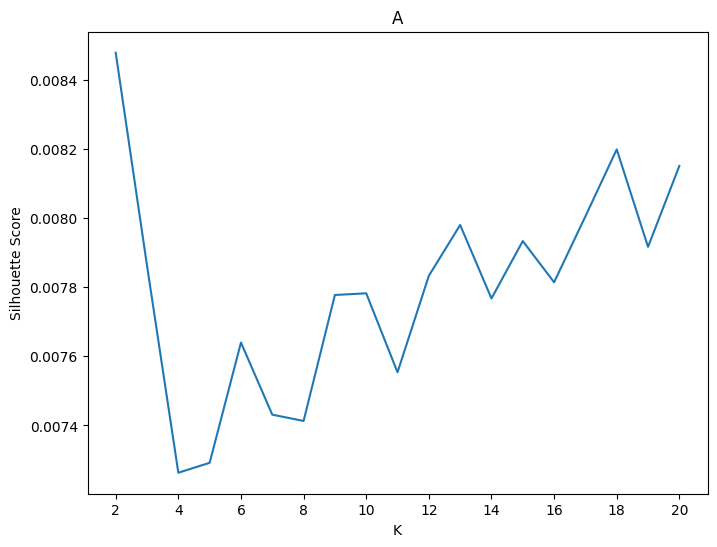

2026-01-27 14:01:37,339 neurocaps.analysis.cap._internals.cluster [INFO] [GROUP: B | METHOD: silhouette] Optimal cluster size is 2.


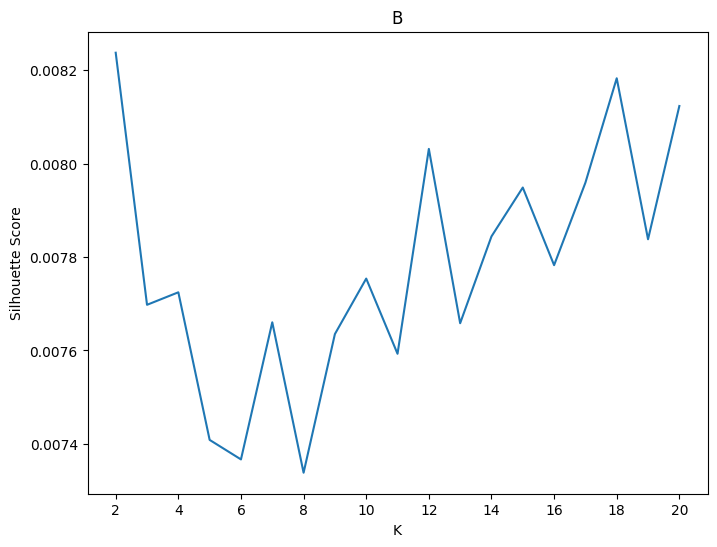

In [26]:
from neurocaps.utils import simulate_subject_timeseries

subject_timeseries = simulate_subject_timeseries(n_subs=8, n_runs=2)


cap_analysis = CAP(groups={"A": ["0", "1", "2", "3"], "B": ["4", "5", "6", "7"]})

plot_kwargs = {**PlotDefaults.get_caps(), "step": 2}

cap_analysis.get_caps(
    subject_timeseries=subject_timeseries,
    n_clusters=range(2, 21),
    cluster_selection_method="silhouette",
    show_figs=True,
    progress_bar=False,
    **plot_kwargs,
)

# The concatenated data can be safely deleted since only the kmeans models and any
# standardization parameters are used for computing temporal metrics.
del cap_analysis.concatenated_timeseries